In [1]:
import numpy as np
import glob
import random
from scipy import sparse

from tools.text_process import LemmaTokenizer
from tools.image_process import getLayerNames, checkLayerNames, image2feature
from models.vectorizer import getVectorizer

# Similarity between category keywords and the description
# suppress cats not in image??**
from tools.image_process import image2SimiFeature

# random image generator, subject to rules
from tools.generator import ranGenLayer

class Dataset():
    def __init__(self, img_dir='images', txt_dir='text'):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.tokenizer = LemmaTokenizer()
        # this operation will process all the text and train a vectorizer
        # so we have double processed the text here
        self.vectorizer = getVectorizer()
        
        # set features
        self.__get_featureNames()
      
    def getOneLayerSent(self, txt_name=None, img_name=None,
                              ran_txt=False, ran_img=False,
                              fake_img=False):
        ##### preprocess
        ## text
        if ran_txt:
            all_txt = glob.glob(self.txt_dir+'/*.txt')
            # rule out current text
            all_txt.remove(txt_name)
            txt_name = random.choice(all_txt)
        else:
            assert(txt_name)
            
        with open(txt_name, 'r') as f:
            orig_sent = f.read()
            sent = self.tokenizer(orig_sent)
            
        ## image
        if ran_img:
            assert img_name
            assert not fake_img
            all_img = glob.glob(self.img_dir+'/*.svg')
            all_img.remove(img_name)
            img_name = random.choice(all_img)
            layers = getLayerNames(img_name)
        elif fake_img:
            assert img_name is None
            assert not ran_img
            layers = ranGenLayer()
        else:
            layers = getLayerNames(img_name)
            
        return layers, sent
    
    def __getEmbed(self, **kwargs):
        
        layers, sent = self.getOneLayerSent(**kwargs)
        
        # tofeature
        txt_embed = self.vectorizer.transform([sent]).toarray()[0]
        img_embed = image2feature(layers)
        joint_embed = image2SimiFeature(layers, sent)
        
        return np.hstack([txt_embed, img_embed, joint_embed])        
    
    def __getitem__(self, ind):
        img_name = '%s/%i.svg' % (self.img_dir, ind+1)
        txt_name = '%s/%i.txt' % (self.txt_dir, ind+1)
        
        # triplets
        triplets = []
        # true match
        triplets.append(self.__getEmbed(txt_name=txt_name,
                                        img_name=img_name))
        # fake image
        triplets.append(self.__getEmbed(txt_name=txt_name,
                                        fake_img=True))
        # mismatched text
        triplets.append(self.__getEmbed(img_name=img_name,
                                        txt_name=txt_name,
                                        ran_txt=True))
        # mismatched image
        triplets.append(self.__getEmbed(img_name=img_name,
                                        txt_name=txt_name,
                                        ran_img=True))
        
        xs = np.vstack(triplets)
        
        # ys
        ys = np.array([1,0,0,0]).reshape(-1,1)
        
        return sparse.csr_matrix(np.hstack([xs, ys]))

    
    def __len__(self):
        return len(glob.glob(self.img_dir+'/*.svg'))
    
    def __get_featureNames(self):
        self.features_ = []
        # text features
        self.vocab_, _ = zip(*sorted(self.vectorizer.vocabulary_.items(),
                                     key=lambda x:x[::-1]))
        self.features_.extend(list(self.vocab_))

        # image features
        from tools.image_process import getNestedKey
        from rules.category import surrouding_dict, person_dict
        self.features_.append('_NLayers_')
        self.features_.extend(['_Background_',
                               '_Surroundings_',
                               '_Person_',
                               '_Decoration_'])
        srd_keys = getNestedKey(surrouding_dict)
        prs_keys = getNestedKey(person_dict)
        self.features_.extend(['_S_%s_' % k for k in srd_keys])
        self.features_.extend(['_P_%s_' % k for k in prs_keys])

        # joint features
        self.features_.extend(['_simi_S_%s_' % k for k in srd_keys])
        self.features_.extend(['_simi_P_%s_' % k for k in prs_keys])

In [1]:
import numpy as np
import glob
import random
from scipy import sparse

from tools.text_process import LemmaTokenizer
from tools.image_process import getLayerNames, checkLayerNames, image2feature, getCrossSimi
from models.vectorizer import getVectorizer

# Similarity between category keywords and the description
# suppress cats not in image??**
from tools.image_process import image2SimiFeature

# random image generator, subject to rules
from tools.generator import ranGenLayer

class Dataset():
    def __init__(self, img_dir='images', txt_dir='text'):
        self.img_dir = img_dir
        self.txt_dir = txt_dir
        self.tokenizer = LemmaTokenizer()
        # this operation will process all the text and train a vectorizer
        # so we have double processed the text here
        self.vectorizer = getVectorizer()
        
        # set features
        self.__get_featureNames()
      
    def getOneLayerSent(self, txt_name=None, img_name=None,
                              ran_txt=False, ran_img=False,
                              fake_img=False):
        ##### preprocess
        ## text
        if ran_txt:
            all_txt = glob.glob(self.txt_dir+'/*.txt')
            # rule out current text
            all_txt.remove(txt_name)
            txt_name = random.choice(all_txt)
        else:
            assert(txt_name)
            
        with open(txt_name, 'r') as f:
            orig_sent = f.read()
            sent = self.tokenizer(orig_sent)
            
        ## image
        if ran_img:
            assert img_name
            assert not fake_img
            all_img = glob.glob(self.img_dir+'/*.svg')
            all_img.remove(img_name)
            img_name = random.choice(all_img)
            layers = getLayerNames(img_name)
        elif fake_img:
            assert img_name is None
            assert not ran_img
            layers = ranGenLayer()
        else:
            layers = getLayerNames(img_name)
            
        return layers, sent
    
    def __flattenSparse(self, matrix):
        return matrix.toarray().flatten()
        
    def __getEmbed(self, **kwargs):
        
        layers, sent = self.getOneLayerSent(**kwargs)
        
        # tofeature
        txt_embed = self.vectorizer.transform([sent]).toarray()[0]
        img_embed = image2feature(layers)
        joint_embed = self.__flattenSparse(getCrossSimi(layers, sent, self.vocab_))
        
        return np.hstack([txt_embed, img_embed, joint_embed])        
    
    def __getitem__(self, ind):
        img_name = '%s/%i.svg' % (self.img_dir, ind+1)
        txt_name = '%s/%i.txt' % (self.txt_dir, ind+1)
        
        # triplets
        triplets = []
        # true match
        triplets.append(self.__getEmbed(txt_name=txt_name,
                                        img_name=img_name))
        # fake image
        triplets.append(self.__getEmbed(txt_name=txt_name,
                                        fake_img=True))
        # mismatched text
        triplets.append(self.__getEmbed(img_name=img_name,
                                        txt_name=txt_name,
                                        ran_txt=True))
        # mismatched image
        triplets.append(self.__getEmbed(img_name=img_name,
                                        txt_name=txt_name,
                                        ran_img=True))
        
        xs = np.vstack(triplets)
        
        # ys
        ys = np.array([1,0,0,0]).reshape(-1,1)
        
        return sparse.csr_matrix(np.hstack([xs, ys]))

    
    def __len__(self):
        return len(glob.glob(self.img_dir+'/*.svg'))
    
    def __get_featureNames(self):
        self.features_ = []
        # text features
        self.vocab_, _ = zip(*sorted(self.vectorizer.vocabulary_.items(),
                                     key=lambda x:x[::-1]))
        self.features_.extend(list(self.vocab_))

        # image features
        from tools.image_process import getNestedKey
        from rules.category import surrouding_dict, person_dict
        self.features_.append('_NLayers_')
        self.features_.extend(['_Background_',
                               '_Surroundings_',
                               '_Person_',
                               '_Decoration_'])
        srd_keys = getNestedKey(surrouding_dict)
        prs_keys = getNestedKey(person_dict)
        self.categ_ = srd_keys + prs_keys
        self.features_.extend(['_S_%s_' % k for k in srd_keys])
        self.features_.extend(['_P_%s_' % k for k in prs_keys])

        # joint features
        self.features_.extend(['_S_%s_%s_' % (k, t) for k in srd_keys for t in self.vocab_])
        self.features_.extend(['_P_%s_%s_' % (k, t) for k in prs_keys for t in self.vocab_])

In [5]:
layers, sent = dataset.getOneLayerSent(txt_name='text/1.txt',
                                       img_name='images/6.svg')
print(layers)
from tools.image_process import getNestedKeyWithCode, getNestedKey
from rules.category import surrouding_dict, person_dict
print(getNestedKeyWithCode(surrouding_dict, [1,1,2]))
print(getNestedKeyWithCode(person_dict, [1,1]))
print(sent)

['A2112', 'A311']
['indoor.a.01', 'object.n.01', 'appliance.n.02']
['interaction.n.01', 'occupation.n.01']
['man.n.01', 'look.v.01', 'chart.n.01', 'back.n.01']


In [3]:
from nltk.corpus import wordnet as wn
for syn in wn.synsets('front'):
    print(syn.name(),':', syn.definition())

front.n.01 : the side that is forward or prominent
battlefront.n.01 : the line along which opposing armies face each other
front.n.03 : the outward appearance of a person
front.n.04 : the side that is seen or that goes first
front_man.n.01 : a person used as a cover for some questionable activity
front.n.06 : a sphere of activity involving effort
front.n.07 : (meteorology) the atmospheric phenomenon created at the boundary between two different air masses
presence.n.02 : the immediate proximity of someone or something
front.n.09 : the part of something that is nearest to the normal viewer
movement.n.04 : a group of people with a common ideology who try together to achieve certain general goals
front.v.01 : be oriented in a certain direction, often with respect to another reference point; be opposite to
front.v.02 : confront bodily
front.a.01 : relating to or located in the front


In [6]:
wn.lch_similarity(wn.synset('stand.v.01'),
                  wn.synset('stand.n.02'))

WordNetError: Computing the lch similarity requires Synset('stand.v.01') and Synset('stand.n.02') to have the same part of speech.

In [52]:
from tools.image_process import getCrossSimi
print(getCrossSimi(layers, sent, dataset.vocab_))

  (1, 4)	1.3350010667323402
  (1, 14)	1.2396908869280152
  (1, 45)	1.8718021769015913
  (1, 50)	1.4403615823901665
  (3, 4)	1.2396908869280152
  (3, 14)	1.1526795099383855
  (3, 50)	1.3350010667323402
  (17, 45)	1.8718021769015913
  (18, 4)	1.3350010667323402
  (18, 14)	1.6916760106710724
  (18, 50)	1.3350010667323402


In [54]:
# sanity check
print(dataset.categ_[1])
print(dataset.categ_[3])
print(dataset.categ_[17])
print(dataset.categ_[18])
print('--')
print(dataset.vocab_[4])
print(dataset.vocab_[14])
print(dataset.vocab_[45])
print(dataset.vocab_[50])
# The problem is, bigrams will never contribute to the cross similarity

concrete
appliance
interact
office
--
back.n.01
chart.n.01
look.v.01
man.n.01


In [29]:
len(dataset.vocab_)

103

In [2]:
from sklearn.linear_model import LogisticRegression
dataset = Dataset()
print('# features: ', len(dataset.features_))
data = sparse.vstack([dataset[i] for i in range(len(dataset))])
X, y = data[:,:-1], data[:,-1]
y = y.toarray().flatten()
print('data shape', data.shape)


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: sideways with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: grid with tag a does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: cell with tag r does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: something with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))


# features:  5852


/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: sideways with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: grid with tag a does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: something with tag n does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))
/Users/dongjustin/Documents/Text2Scene/Text2Scene/tools/text_process.py:48: UserWarning: cell with tag r does not belong to any synsets.
  warnings.warn('%s with tag %s does not belong to any synsets.' % (lemma, tag))


data shape (148, 5853)


In [5]:
from nltk.corpus import wordnet as wn

In [19]:
clf = LogisticRegression(# random_state=0,
                         solver='liblinear',
                         class_weight={1: 1, 0:0.5},
                         penalty='l1', #'l2' use l1 to learn sparsely
                         C=1.0,
                         max_iter=100)

# clf.fit(X[:40], y[:40])
clf.fit(X, y)

LogisticRegression(C=1.0, class_weight={0: 0.5, 1: 1}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
import matplotlib.pyplot as plt

Accuracy:  0.8611111111111112


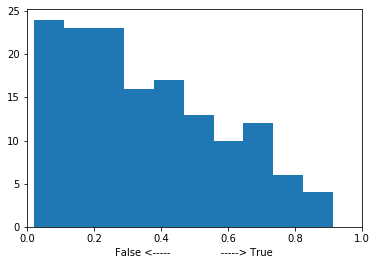

In [24]:
print('Accuracy: ', clf.score(X[40:],y[40:]))
# print(clf.predict(X))
# print(clf.predict_proba(X)[:,1])
# print(y)
plt.hist(clf.predict_proba(X)[:,1])
plt.xlabel('False <-----                -----> True')
plt.xlim([0, 1])
plt.show()

In [20]:
d = dict(zip(dataset.features_, clf.coef_.tolist()[0]))
sorted(d.items(), key=lambda x: abs(x[1]))[::-1]

[('_P_stand.v.01_watch.v.01_', 1.5391293715763754),
 ('_S_chart.n.01_icon.n.01_', 1.1861081854697846),
 ('_S_chart.n.01_chart.n.01_', 1.0059071227679186),
 ('_P_interaction.n.01_', 0.8835713636594164),
 ('chart.n.01', -0.8555388980052264),
 ('_P_back.n.01_back.n.01_', 0.811419493996635),
 ('_S_nature.n.03_rock.n.01_', 0.7656419139634725),
 ('_P_stand.v.01_stand.v.01_', 0.7502904292039995),
 ('_P_show.v.01_show.v.01_', 0.7216844761455998),
 ('_P_sit.v.01_sit.v.01_', 0.6003908841951197),
 ('_P_enjoyment.n.02_woman.n.01_', 0.5156330989756293),
 ('_P_interaction.n.01_chart.n.01_', -0.48393492313421155),
 ('_S_street.n.01_street.n.01_', 0.36420623141955577),
 ('_NLayers_', -0.3605950539552541),
 ('stand.v.01', -0.25139856395092425),
 ('_S_chart.n.01_', -0.24023345302641375),
 ('_P_interaction.n.01_man.n.01_', 0.22308507610624875),
 ('icon.n.01', -0.22042836307758099),
 ('man.n.01', -0.21055596725312886),
 ('_S_object.n.01_man.n.01_', 0.17306414475043982),
 ('_S_vehicle.n.01_airplane.n.01_',

In [7]:
# todo - unseen keywords